# Credit to Dongwoo Kim

https://github.com/arongdari/python-topic-model/

In [ ]:
#mount your drive
from google.colab import drive
drive.mount('drive')



Mounted at drive


In [ ]:
#!ls drive/My\ Drive
import os

########## CHEMINS CI DESSOUS A MODIFIER ############
path_to_ptm = 'drive/My Drive/IAAA/Colab/'
###################################################
os.chdir(path_to_ptm)
!ls

cora  logs  ptm  tfidf_transform.py  tfidf_transform.pyc


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys

sys.path.append(path_to_ptm)

import os
os.environ['PYTHONPATH'] += ":" + path_to_ptm

!echo path_to_ptm
!echo $PYTHONPATH

path_to_ptm
/env/python:drive/My Drive/IAAA/Colab/





# Exemple of AuthorTopicModel 

"The Author-Topic Model for Authors and Documents" by Rosen-Zvi, et al. (UAI 2004)

In [ ]:
import pickle
import logging

import time
import math

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from ptm import AuthorTopicModel##
from ptm.utils import convert_cnt_to_list, get_top_words##

logger = logging.getLogger('AuthorTopicModel')
logger.propagate=False

%matplotlib inline

## Dataset CORA

Dataset originel disponible à : https://people.cs.umass.edu/~mccallum/data.html

In [ ]:
PATH_to_Data_Cora="./"
doc_ids = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_ids.pkl', 'rb'))
doc_cnt = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_cnt.pkl', 'rb'))
doc_author = pickle.load(open(PATH_to_Data_Cora + 'cora/doc_authorid.pkl', 'rb'))
author_name = pickle.load(open(PATH_to_Data_Cora + 'cora/authorid_authorname.pkl', 'rb'))
voca = pickle.load(open(PATH_to_Data_Cora + 'cora/voca.pkl', 'rb'))




In [ ]:
print(len(voca))
print(author_name)

17059
{0: '', 1: 'R Bello', 2: 'A Reeves', 3: 'J Aagaard', 4: 'M Boris', 5: 'R Bol', 6: 'J Bryan', 7: 'J Kukula', 8: 'R Bod', 9: 'R Haddleton', 10: 'G Fedder', 11: 'S Mishra', 12: 'O Gotoh', 13: 'I Porche', 14: 'R Lakshmanan', 15: 'M Koppel', 16: 'M Shimada', 17: 'R Rubinoff', 18: 'J McLurkin', 19: 'R Schwarz', 20: 'R Andr', 21: 'G Fischer', 22: 'I Moulitsas', 23: 'A Carmi', 24: 'K Sutherland', 25: 'J Hendleryz', 26: 'F Jelinek', 27: 'D Fan', 28: 'J Platt', 29: 'J Fox', 30: 'V Krishnan', 31: 'C Bettini', 32: 'K Ehrlich', 33: 'B Dzafic', 34: 'A Bayya', 35: 'M Walker', 36: 'D Martin', 37: 'D Vollmar', 38: 'H Mai', 39: 'P Freedman', 40: 'I Csabai', 41: 'I Yanasak', 42: 'R Mattikalli', 43: 'C Cargnoni', 44: 'C Associate', 45: 'B Raman', 46: 'M Mahowald', 47: 'C Kolias', 48: 'S Jeremy', 49: 'R CameronJones', 50: 'N Medvidovic', 51: 'K Hartojo', 52: 'C Findler', 53: 'H Nelson', 54: 'N Huang', 55: 'D Robb', 56: 'H Toetenel', 57: 'K Vanhoof', 58: 'J Tardo', 59: 'J Berman', 60: 'L Porkolab', 61

### Contenu des structures de données
- voca : 
C'est une liste des mots du vocabulaire de l'ensemble des documents. Les autres structures de données font référence aux indices des ots dans cette liste. 
- author_name : 
C'est une liste des auteurs de l'ensemble des documents. Les autres structures de données font référence aux indices des auteurs dans cette liste. 
- doc_author : 
C'est une liste de listes (une par document). La liste d'un document contient les indices des auteurs du document 
- doc_ids : 
C'est une liste de listes (une par document). La liste d'un document contient les indices des mots apparaissant dans le document 
- doc_cnt :
C'est une liste de listes (une par document). La liste d'un document contient le nombre de fois qu'apparait chaque mot du document tel que spédicifié dans la liste correspondante dans doc_ids 


In [ ]:
print len(doc_ids) # 13147 -> nb de documents
print len(doc_cnt) # 13147 
print len(doc_author) # 13147 
print len(author_name) # 24886 -> nb d'auteur
print len(voca) # # 17059 -> nb de mots, moins de mots que l'auteur !
print len(doc_ids[1]) # 88 -> il y a 88 mots dans le document 1
print doc_ids[1] # [13910, 4518, 10249, .. etc] le mots numéro 13910 apparaît.
print doc_cnt[1] # [1, 1, 1,... ] homomorphism apparaît une fois
print doc_author[1] # [1174, 18535, 9596] l'auteur 1174, auteur 18535 et auteur 9596
print voca[1] # homomorphism
print author_name[1] # R Bello


13147
13147
13147
24486
17059
88
[13910, 4518, 10249, 16914, 4627, 15383, 15903, 8736, 10786, 14970, 551, 7720, 2613, 1033, 15419, 5692, 3645, 10816, 14913, 10819, 16452, 12872, 14412, 16982, 2135, 5307, 13414, 9845, 17014, 5753, 7290, 4226, 7815, 7826, 10388, 13978, 11419, 9887, 8870, 1710, 2226, 6329, 2235, 10432, 14542, 6362, 16091, 16092, 6778, 9467, 5379, 9990, 3335, 16137, 7441, 3352, 16666, 15132, 7453, 11553, 14630, 647, 2348, 15166, 15684, 8518, 14667, 11622, 3434, 1389, 16756, 13689, 2440, 13713, 12189, 9638, 13234, 6072, 7839, 15811, 7625, 13771, 2519, 4058, 10715, 4579, 4069, 7167]
[1, 1, 1, 1, 2, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 4, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 2, 3, 1, 2, 1, 4, 1, 3, 1, 2, 1, 1, 3, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 3, 1, 9, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 9, 1]
[1174, 18535, 9596]
homomorphism
R Bello


In [ ]:
corpus = convert_cnt_to_list(doc_ids, doc_cnt) # donc là on créé concrètement les textes : doc_ids dit que le mot 13910 apparaît et doc_cnt dit combien de fois il apparâit. On fait ça pour tous les documents.
n_doc = len(corpus) # c'est corpus est un ensemble de 13147 textes/documents.
n_author = len(author_name)
n_voca = len(voca)

print n_doc
print n_author
print n_voca

13147
24486
17059


La fonction convert_cnt_to_list crée une structure de type liste de listes (une par document). La  liste d'un document contient l'ensemble des mots (des indices de mots) du document, éventuellement avec répétitions. 

In [ ]:
print corpus[1] # le premier texte
print np.sum(doc_cnt[1]) # le nombre de mots dans le premier document.

[13910, 4518, 10249, 16914, 4627, 4627, 15383, 15903, 8736, 10786, 14970, 14970, 14970, 14970, 14970, 14970, 14970, 551, 7720, 2613, 1033, 15419, 5692, 5692, 5692, 5692, 3645, 10816, 14913, 14913, 14913, 10819, 16452, 12872, 12872, 12872, 14412, 14412, 14412, 16982, 2135, 5307, 5307, 13414, 9845, 17014, 5753, 7290, 4226, 4226, 4226, 7815, 7826, 7826, 10388, 10388, 10388, 13978, 11419, 11419, 9887, 8870, 8870, 8870, 8870, 1710, 2226, 2226, 2226, 6329, 2235, 2235, 10432, 14542, 6362, 6362, 6362, 16091, 16092, 6778, 6778, 9467, 9467, 5379, 9990, 3335, 16137, 7441, 3352, 16666, 15132, 7453, 11553, 14630, 14630, 647, 647, 2348, 2348, 15166, 15684, 15684, 15684, 8518, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 14667, 11622, 3434, 1389, 16756, 13689, 2440, 13713, 12189, 12189, 12189, 9638, 13234, 6072, 7839, 15811, 7625, 13771, 2519, 2519, 2519, 4058, 10715, 10715, 4579, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 4069, 7167]
147


## Prétraitement des données et représentations tf-idf

In [ ]:
#!ls 
#!pwd
import numpy as np

from tfidf_transform import tf_idf_transform

In [ ]:
data = tf_idf_transform(corpus, doc_ids, n_doc, n_voca) 
#17059 ligne pour chaque mots de vocabulaire et 13147 colonnes pour chaque documents. On fait une disivion par n_doc = len(corpus[i]). Donc c'est un pourcentage sur le doc i.


1.4317688942
2.43782806396


In [ ]:
# print (data[100:300,2]) # le troisième document, 17000 valeurs, plein de 0 car très peu de mots sont utilisés par documents.
print np.sum(data[:,1])
print(len(data))
print(len(data[0]))

162.4308302296014
17059
13147


## Clustering avec K-means et bag-of-words





En utilisant KMeans vous pouvez clusteriser les documents, en suposant qu'il s vint être r&ssemblés selon le facteur le plus important dans la similarité entre documents, le sujet dont ils parlent. 

Après apprentissage du KMeans vous pouvez identifier les termes les plus populaires dans les documents associés à un cluster et ainsi deviner de quel topic il s'agit.

### Apprentissage de modèles

Apprenez plusieurs modèles avec KMeans en variant le nombre de clusters et éventuellement la nature de la représentation.

Voir fin du notebook pour le travail à faire.
 

### Analyse des resultats

Pour identifer les topics appris (cad. les clusters): 
  - afficher les mots les plus fréquents et discriminants (maximums des descripteurs)
  - afficher la population de chaque cluster
  - calculer une matrice de similarité entre les différents clusters


#### Utile:

- Vous pouvez utilser une représentation bag-of-words à partir des descripteurs initiaux ou bien utiliser une représentation tf-idf
- Vous utiliserez sklearn.cluster.KMeans pour apprendre le modèle k-means
- Vous pouvez ou pas normaliser vos dnnées (centrées réduites, norme L2 etc)

In [ ]:
#NOTES BROUILLON

# aller voir sur le site pour les exemples, à utiliser. pour le clustering à l'aide distance euclidienne ou mesure cosinus (mesure de similarité)
# puis essayer de comprendre ce que le clustering a fait. prendre un cluster et regarder l'ensemble des mots les plus fréquents dans ce cluster.
# interpreter le contenu en fonction des mots les plus fréquents.
# afficher les mots les plus discrimants et fréquents : les mots avec les plus gros tf idf. En effet, c'est le mots le plus présent dans le cluster sans l'être dans l'ensemble des documents.
# on peut cherche des mesures de similarité entre deux clusters : ça peut être à l'aide des vecteurs centre des clusters
# on peut utiliser les bag of word qui sont dispo juste avant le tf idf
# on peut normaliser chaque document. Si on prend un document de 100 mots, si on calcule sa représentation. On prend ce document on le duplique à 10000 mots. Alors ils auront la même représentation.
# Donc nos représentations ne sont pas pollués par la longueur des documents.

In [ ]:
#KMEANS

from sklearn.cluster import KMeans
import numpy as np
from time import time
import matplotlib.pyplot as plt

max_iter=3
n_topic=10 #on décide de 10 topics donc clustering avec 10 topics.

t0 = time()
km = KMeans(n_clusters=n_topic, random_state=0).fit(data.T) #si on met juste data on obtient des vecteurs centres sur les documents et non sur les mots
print("done in %0.3fs" % (time() - t0))

done in 464.378s


In [ ]:
print(len(km.labels_)) #classement de chaque mots dans un des topics
print(km.labels_[0:100])
print(len(km.cluster_centers_)) #10 centres/ligne
print(len(km.cluster_centers_[0])) #chaque centre possède 17 059 colonnes soit un coef par mots
# print(len(km.cluster_centers_[1]))
# print(km.cluster_centers_[0][0:20])
# print(km.cluster_centers_[1][0:20])

def main_word(tab):
  max = tab[0]
  indice = 0
  for i in range(1, len(tab)) :
    if max < tab[i]:
      max = tab[i]
      indice = i
  return (max,voca[indice])

# main_word(km.cluster_centers_[0])

def max_top_10(tab):
  top10 = []
  topindice = tab.argsort()[-10:][::-1]
  for x in topindice:
    top10.append(voca[x])
  return top10

# max_top_10(km.cluster_centers_[0])
# max_top_10(km.cluster_centers_[1])

#ANALYSE DES RESULTATS

for ti in range(n_topic):
    top_words = max_top_10(km.cluster_centers_[ti])
    print('Topic', ti ,': ', ','.join(top_words))




13147
[9 7 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 7 9 9 9 9 9 6 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 7 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]
10
17059
('Topic', 0, ': ', u'multicast,group,protocol,message,receiver,mbone,delivery,tree,loss,session')
('Topic', 1, ': ', u'garbage,collector,collection,heap,pointer,write,noncopying,copying,must,realtime')
('Topic', 2, ': ', u'schema,view,evolution,change,objectoriented,database,realtime,rompp,conceptual,transparent')
('Topic', 3, ': ', u'abstraction,model,level,object,system,thread,program,behavior,state,case')
('Topic', 4, ': ', u'plan,planner,planning,agent,action,belief,state,revision,information,goal')
('Topic', 5, ': ', u'polysilicon,layer,psg,fig,ferromagnetic,mmthick,deposited,etch,wafer,resist')
('Topic', 6, ': ', u'service,communication,memory,protocol,cache,system,message,traffic,resource,data')
('Topic', 7, ': ', u'program,compiler,analysis,code,dependence,data,i

In [146]:
#MESURE DE SIMILARITE KMEANS

def mesure_cosinus(x,y):
  z = np.vdot(x,y)
  z = z/np.linalg.norm(x)
  z = z/np.linalg.norm(y)
  return z

def similarite_kmeans():
  M = np.zeros((10, 10))
  for i in range(n_topic):
    for j in range(i+1,n_topic):
      if M[i][j] == 0:
        M[i][j] = mesure_cosinus(km.cluster_centers_[i],km.cluster_centers_[j])
  return M

# print(similarite_kmeans())

def distance_kmeans():
  M = np.zeros((10, 10))
  max = 0
  min = 100
  somme = 0
  indice1 = 0
  indice2 = 0
  indice3 = 0
  indice4 = 0
  for i in range(n_topic):
    for j in range(i+1,n_topic):
      if M[i][j] == 0:
        M[i][j] = mesure_cosinus(km.cluster_centers_[i],km.cluster_centers_[j])
        somme = somme + M[i][j]

        if max < M[i][j]:
          max = M[i][j]
          indice1 = i
          indice2 = j
        
        if min > M[i][j]:
          min = M[i][j]
          indice3 = i
          indice4 = j

  return [max,indice1,indice2,min,indice3,indice4,somme/45]

print(distance_kmeans())


[0.6278426749817498, 6, 9, 0.005171655542511057, 5, 8, 0.14473357606387915]


## LDA

Vous pouvez utiliser le package *ptm* qui implémente de nombreux modèles à variables latentes, en utilisant le code des cellules suivantes. 

In [ ]:
from ptm import GibbsLDA # genre de modèle que l'on apprend avec du EM et du Gibbs Sampling. Un topic est une distribution de mots.

max_iter=3
n_topic=10 

modelLDA = GibbsLDA(n_doc, len(voca), n_topic)
modelLDA.fit(corpus, max_iter=max_iter)

# on voit que cela ressort la vraisemblance. et elle augmente au fur des itérations.

2020-11-09 15:19:51 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.80,	log_likelihood:-10867311.03
2020-11-09 15:20:04 INFO:GibbsLDA:[ITER] 1,	elapsed time:12.84,	log_likelihood:-10533530.13
2020-11-09 15:20:17 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.93,	log_likelihood:-10283396.43


### Analyse des résultats

Identifiez les 10 mots les plus probables pour chaque topic appris.

In [ ]:
for ti in range(n_topic):
    top_words = get_top_words(modelLDA.TW, voca, ti, n_words=10) 
    print('Topic', ti ,': ', ','.join(top_words))

('Topic', 0, ': ', u'system,algorithm,paper,data,program,problem,model,application,present,network')
('Topic', 1, ': ', u'system,algorithm,problem,paper,data,model,method,new,approach,performance')
('Topic', 2, ': ', u'system,problem,algorithm,paper,model,data,network,result,performance,approach')
('Topic', 3, ': ', u'system,algorithm,model,paper,problem,using,application,learning,network,data')
('Topic', 4, ': ', u'system,algorithm,paper,model,problem,application,network,language,show,data')
('Topic', 5, ': ', u'system,algorithm,model,paper,data,performance,problem,using,approach,network')
('Topic', 6, ': ', u'system,algorithm,paper,model,performance,data,problem,application,network,using')
('Topic', 7, ': ', u'system,algorithm,paper,problem,network,model,data,result,using,performance')
('Topic', 8, ': ', u'system,algorithm,paper,problem,network,application,method,performance,result,data')
('Topic', 9, ': ', u'system,algorithm,problem,paper,model,approach,program,application,data,set'

In [128]:
print(len(modelLDA.TW)) #10 vecteurs centres/lignes
print(len(modelLDA.TW[0])) #17059 colonnes soit coefficient par mots

def similarite(model):
  M = np.zeros((10, 10))
  for i in range(n_topic):
    for j in range(i+1,n_topic):
      if M[i][j] == 0:
        M[i][j] = mesure_cosinus(model.TW[i],model.TW[j])
  return M

def distance(model):
  M = np.zeros((10, 10))
  max = 0
  min = 100
  somme = 0
  indice1 = 0
  indice2 = 0
  indice3 = 0
  indice4 = 0
  for i in range(n_topic):
    for j in range(i+1,n_topic):
      if M[i][j] == 0:
        M[i][j] = mesure_cosinus(model.TW[i],model.TW[j])
        somme = somme + M[i][j]

        if max < M[i][j]:
          max = M[i][j]
          indice1 = i
          indice2 = j
        
        if min > M[i][j]:
          min = M[i][j]
          indice3 = i
          indice4 = j

  return [max,indice1,indice2,min,indice3,indice4,somme/45]

print(distance(modelLDA))


10
17059
[0.9321246958407845, 1, 3, 0.9064866659837315, 5, 6, 0.9216112374473604]


2020-11-09 18:35:57 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.58,	log_likelihood:-10867364.23
2020-11-09 18:36:12 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.85,	log_likelihood:-10866177.43
2020-11-09 18:36:27 INFO:GibbsLDA:[ITER] 1,	elapsed time:14.47,	log_likelihood:-10530959.67
2020-11-09 18:36:42 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.66,	log_likelihood:-10867479.37
2020-11-09 18:36:54 INFO:GibbsLDA:[ITER] 1,	elapsed time:12.50,	log_likelihood:-10531227.30
2020-11-09 18:37:07 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.72,	log_likelihood:-10283333.16
2020-11-09 18:37:22 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.70,	log_likelihood:-10866210.40
2020-11-09 18:37:35 INFO:GibbsLDA:[ITER] 1,	elapsed time:13.07,	log_likelihood:-10531768.51
2020-11-09 18:37:48 INFO:GibbsLDA:[ITER] 2,	elapsed time:12.70,	log_likelihood:-10276897.81
2020-11-09 18:38:01 INFO:GibbsLDA:[ITER] 3,	elapsed time:12.63,	log_likelihood:-10083717.67
2020-11-09 18:38:16 INFO:GibbsLDA:[ITER] 0,	elapsed time:12.75,	log_likelihood:-

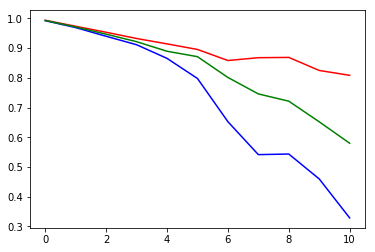

In [ ]:
def statistique_similarite(n_iteration):
  Mat_max = []
  Mat_min = []
  Mat_moyen = []
  X = np.arange(n_iteration+1)
  for i in range(0,n_iteration+1):
    model = GibbsLDA(n_doc, len(voca), n_topic)
    model.fit(corpus, max_iter=i)
    resultat = distance(model)
    Mat_max.append(resultat[0])
    Mat_min.append(resultat[3])
    Mat_moyen.append(resultat[6])
  plt.plot(X,Mat_max,'r') #rouge, similarité maximale
  plt.plot(X,Mat_min,'b') #bleu, similarité minimale
  plt.plot(X,Mat_moyen,'g') #vert, similarité moyenne

statistique_similarite(10)

#Commentaire :

#La similarité maximale, minimale et moyenne diminuent lorsque l'on augmente le nombre d'itérations. Selon la mesure cosinus, plus la mesure diminue, plus l'angle entre les vecteurs augmentent.

#Les vecteurs centres des topics les plus proches, s'écarte légèrement.
#Tandis que les vecteurs centres des topics les plus éloignés, s'écarte encore plus fortement.
#La similitudes moyennes suit ces deux tendances baissières. 

##  Modèle author-topic

In [ ]:
max_iter=3
n_topic=10

modelAT = AuthorTopicModel(n_doc, n_voca, n_topic, n_author)

modelAT.fit(corpus, doc_author, max_iter=max_iter)

2020-11-09 19:04:18 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:31.11	log_likelihood:-10864303.34
2020-11-09 19:04:49 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:31.20	log_likelihood:-10646847.49
2020-11-09 19:05:21 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:31.04	log_likelihood:-10489177.82


### Analyse: Les 10 mots les plus probables pour chaque topic

In [ ]:
for k in range(n_topic):
    top_words = get_top_words(modelAT.TW, voca, k, 10)
    print('topic ', k , ','.join(top_words))

('topic ', 0, u'system,algorithm,paper,problem,performance,data,network,program,using,application')
('topic ', 1, u'system,algorithm,problem,model,paper,data,learning,present,using,performance')
('topic ', 2, u'system,algorithm,model,paper,problem,data,application,performance,new,method')
('topic ', 3, u'system,paper,algorithm,problem,network,model,data,method,used,performance')
('topic ', 4, u'system,algorithm,paper,problem,model,performance,network,result,application,using')
('topic ', 5, u'system,algorithm,paper,model,data,problem,application,program,performance,technique')
('topic ', 6, u'system,algorithm,application,problem,data,paper,model,network,method,design')
('topic ', 7, u'system,algorithm,paper,model,problem,network,method,parallel,approach,learning')
('topic ', 8, u'system,algorithm,network,model,problem,paper,present,data,performance,application')
('topic ', 9, u'system,paper,data,problem,algorithm,model,performance,result,network,program')


10
17059
[0.9273150136062411, 2, 5, 0.9028095690094187, 1, 6, 0.9161069439745493]


2020-11-09 19:09:29 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:30.98	log_likelihood:-10864305.48
2020-11-09 19:10:21 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:31.12	log_likelihood:-10863257.75
2020-11-09 19:10:52 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:31.01	log_likelihood:-10645384.10
2020-11-09 19:11:45 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:31.22	log_likelihood:-10864200.41
2020-11-09 19:12:17 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:31.29	log_likelihood:-10646879.50
2020-11-09 19:12:52 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:35.10	log_likelihood:-10488691.27
2020-11-09 19:13:44 INFO:AuthorTopicModel:[INIT] 0	elapsed_time:31.14	log_likelihood:-10862282.22
2020-11-09 19:14:15 INFO:AuthorTopicModel:[INIT] 1	elapsed_time:31.00	log_likelihood:-10646725.99
2020-11-09 19:14:46 INFO:AuthorTopicModel:[INIT] 2	elapsed_time:31.06	log_likelihood:-10490228.50
2020-11-09 19:15:18 INFO:AuthorTopicModel:[INIT] 3	elapsed_time:31.18	log_likelihood:-10355685.16
2020-11-09 19:16:10 

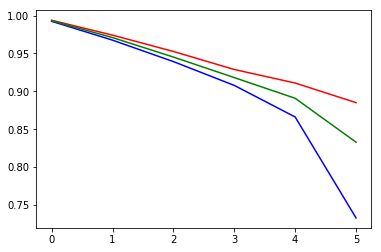

In [ ]:
print(len(modelAT.TW)) #10 vecteurs centres/lignes
print(len(modelAT.TW[0])) #17059 colonnes soit coefficient par mots

print(distance(modelAT))

def statistique_similarite_AT(n_iteration):
  Mat_max = []
  Mat_min = []
  Mat_moyen = []
  X = np.arange(n_iteration+1)
  for i in range(0,n_iteration+1):
    model = AuthorTopicModel(n_doc, n_voca, n_topic, n_author)
    model.fit(corpus, doc_author, max_iter=i)
    resultat = distance(model)
    Mat_max.append(resultat[0])
    Mat_min.append(resultat[3])
    Mat_moyen.append(resultat[6])
  plt.plot(X,Mat_max,'r') #rouge
  plt.plot(X,Mat_min,'b') #bleu
  plt.plot(X,Mat_moyen,'g') #vert

statistique_similarite_AT(5)

### Afficher la distribution sur les topics pour quelques auteurs particuliers

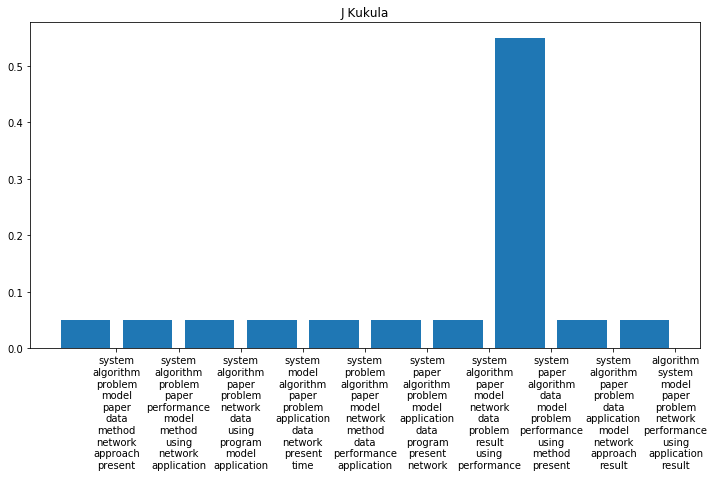

In [ ]:
author_id = 7
fig = plt.figure(figsize=(12,6))
plt.bar(range(n_topic), modelAT.AT[author_id]/np.sum(modelAT.AT[author_id]))
plt.title(author_name[author_id])
plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(modelAT.TW, voca, k, 10)) for k in range(n_topic)])
plt.show()
modelAT

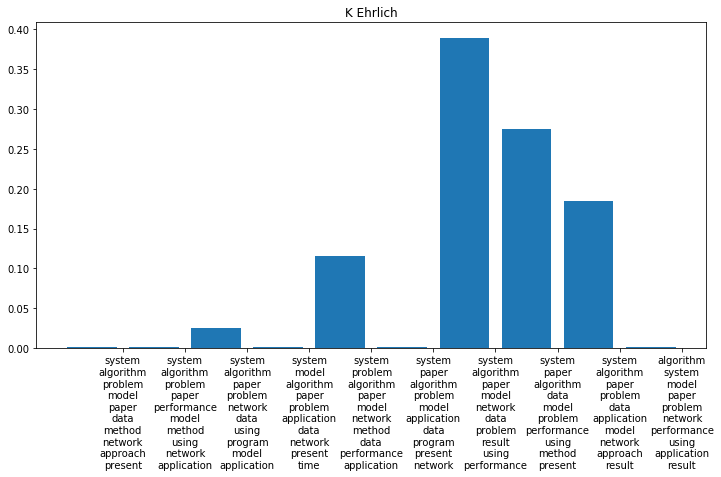

In [ ]:
author_id = 32
fig = plt.figure(figsize=(12,6))
plt.bar(range(n_topic), modelAT.AT[author_id]/np.sum(modelAT.AT[author_id]))
plt.title(author_name[author_id])
plt.xticks(np.arange(n_topic)+0.5, ['\n'.join(get_top_words(modelAT.TW, voca, k, 10)) for k in range(n_topic)])
plt.show()

# Travail à faire

    1. Caractériser les solutions trouvées par les méthodes proposées (KMeans, LDA, Author-Topic model):
    - Définir une mesure de similarité entre topics. 
    - Calculer le degré de similarité minimmum, maximum et moyen entre deux topics en fonction du nombre d'itérations d'apprentissage de LDA et de AuthorTopic.
    - Tracer les courbes de ces statistiques des similarités pour plusieurs nombres de topics en fonction du nombre d'itérations. 
    2. Faire une figure situant les différents modèles testés en termes de vraisemblance des données (abscisse) et similarité moyenne (ordonnée).
    3. Il est possible d'utiliser les modèles AuthorTopic appris pour déterminer pour un document donné quels mots ont été écrits par quel auteur. Ecrivez le code correspondant en vous inspirant des codes de LDA et AuthorTopic pour calculer les probabilités nécessaires. 

(-23318065.136697575, -10283396.429204991, -10489177.82417109)


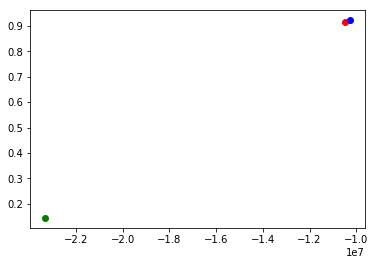

In [147]:
#2.

#nombre d'iterations est de 3
logAT = modelAT.log_likelihood()
logLDA = modelLDA.log_likelihood(corpus)
logKmeans = km.score(data.T)
resultatAT = distance(modelAT)[6]
resultatLDA = distance(modelLDA)[6]
resultatKmeans = distance_kmeans()[6]

print(logKmeans, logLDA, logAT)

plt.plot(logAT,resultatAT,'ro',label='Author-Topic')
plt.plot(logLDA,resultatLDA,'bo',label='LDA')
plt.plot(logKmeans,resultatKmeans,'go',label='Kmeans')
plt.show()